In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-07-07/coffee_ratings.csv"
df = pd.read_csv(url)

In [ ]:
coffee_df = df[['total_cup_points',
                            'species',
                            'country_of_origin',
                            'variety',
                            'aroma',
                            'aftertaste',
                            'acidity',
                            'body',
                            'balance',
                            'sweetness',
                            'altitude_mean_meters',
                            'moisture']]
coffee_df = coffee_df.dropna()

In [ ]:
coffee_df.to_csv('coffee_df.csv', index=False)

In [4]:
coffee_df = pd.read_csv('coffee_df.csv')

In [7]:
le = LabelEncoder()
categorical_cols = ['species', 'country_of_origin', 'variety']
for col in categorical_cols:
    coffee_df[col] = le.fit_transform(coffee_df[col].astype(str))

In [8]:
coffee_df = coffee_df[coffee_df['aroma'] > 0]
coffee_df = coffee_df[coffee_df['acidity'] > 0]

In [9]:
rating_pctile = np.percentile(coffee_df['total_cup_points'], [75, 90])
coffee_df['n_rating'] = 0
coffee_df['n_rating'] = np.where(coffee_df['total_cup_points'] < rating_pctile[0], 1, coffee_df['n_rating'])
coffee_df['n_rating'] = np.where((coffee_df['total_cup_points'] >= rating_pctile[0]) &
                               (coffee_df['total_cup_points'] <= rating_pctile[1]), 2, coffee_df['n_rating'])
coffee_df['n_rating'] = np.where(coffee_df['total_cup_points'] > rating_pctile[1], 3, coffee_df['n_rating'])

In [10]:
X = coffee_df.drop(['total_cup_points', 'n_rating', 'sweetness', 'species', 'altitude_mean_meters'], axis=1)
y = coffee_df['n_rating']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [13]:
param_dist = {
    'n_estimators': np.linspace(100, 3000, 15, dtype=int),
    'max_depth': [1, 5, 10, 20, 50, 100, 150, 200],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 3, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

In [14]:
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                 n_iter=30, cv=5, verbose=2, random_state=42, n_jobs=4)
random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=30, n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 5, 10, 20, 50, 100,
                                                      150, 200],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'n_estimators': array([ 100,  307,  514,  721,  928, 1135, 1342, 1550, 1757, 1964, 2171,
       2378, 2585, 2792, 3000])},
                   random_state=42, verbose=2)

In [15]:
print("Найкращі параметри RandomizedSearchCV:", random_search.best_params_)

Найкращі параметри RandomizedSearchCV: {'n_estimators': np.int64(928), 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 20, 'criterion': 'gini', 'bootstrap': False}


In [16]:
print("Точність на тренувальних даних (RandomizedSearchCV):", random_search.score(X_train_scaled, y_train))
print("Точність на тестових даних (RandomizedSearchCV):", random_search.score(X_test_scaled, y_test))

Точність на тренувальних даних (RandomizedSearchCV): 0.9852744310575636
Точність на тестових даних (RandomizedSearchCV): 0.8755020080321285


In [17]:
param_grid = {
    'n_estimators': np.linspace(random_search.best_params_['n_estimators']-100,
                              random_search.best_params_['n_estimators']+100, 5, dtype=int),
    'max_depth': [random_search.best_params_['max_depth']-30,
                  random_search.best_params_['max_depth'],
                  random_search.best_params_['max_depth']+30],
    'min_samples_split': [random_search.best_params_['min_samples_split'],
                         random_search.best_params_['min_samples_split']+1],
    'min_samples_leaf': [random_search.best_params_['min_samples_leaf'],
                        random_search.best_params_['min_samples_leaf']+1]
}

In [18]:
rf_grid = RandomForestClassifier(criterion=random_search.best_params_['criterion'],
                                bootstrap=random_search.best_params_['bootstrap'],
                                random_state=42)
grid_search = GridSearchCV(estimator=rf_grid, param_grid=param_grid, cv=5, n_jobs=4, verbose=2)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


E:\Programming\pythonProj\year_2025\khpi_spring_sem\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
100 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "E:\Programming\pythonProj\year_2025\khpi_spring_sem\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\Programming\pythonProj\year_2025\khpi_spring_sem\.venv\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "E:\Programming\pythonProj\year_2025\khpi_spring_sem\.venv\Lib\site-packages\

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(bootstrap=False, random_state=42),
             n_jobs=4,
             param_grid={'max_depth': [-10, 20, 50], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [10, 11],
                         'n_estimators': array([ 828,  878,  928,  978, 1028])},
             verbose=2)

In [19]:
print("Найкращі параметри GridSearchCV:", grid_search.best_params_)

Найкращі параметри GridSearchCV: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 11, 'n_estimators': np.int64(878)}


In [20]:
print("Точність на тренувальних даних (GridSearchCV):", grid_search.score(X_train_scaled, y_train))
print("Точність на тестових даних (GridSearchCV):", grid_search.score(X_test_scaled, y_test))

Точність на тренувальних даних (GridSearchCV): 0.9825970548862115
Точність на тестових даних (GridSearchCV): 0.8714859437751004


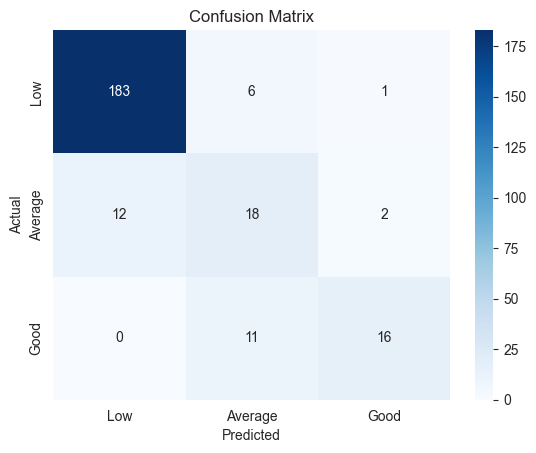

In [21]:
conf_matrix = metrics.confusion_matrix(y_test, grid_search.predict(X_test_scaled), labels=[1, 2, 3])
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Low', 'Average', 'Good'],
           yticklabels=['Low', 'Average', 'Good'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
plt.close()

In [22]:
feature_importance = pd.DataFrame(grid_search.best_estimator_.feature_importances_,
                                 index=X.columns, columns=['Importance']).sort_values('Importance', ascending=False)
print("\nВажливість ознак:\n", feature_importance)


Важливість ознак:
                    Importance
balance              0.244064
aftertaste           0.225527
acidity              0.196387
aroma                0.151925
body                 0.108787
country_of_origin    0.028916
variety              0.023713
moisture             0.020682


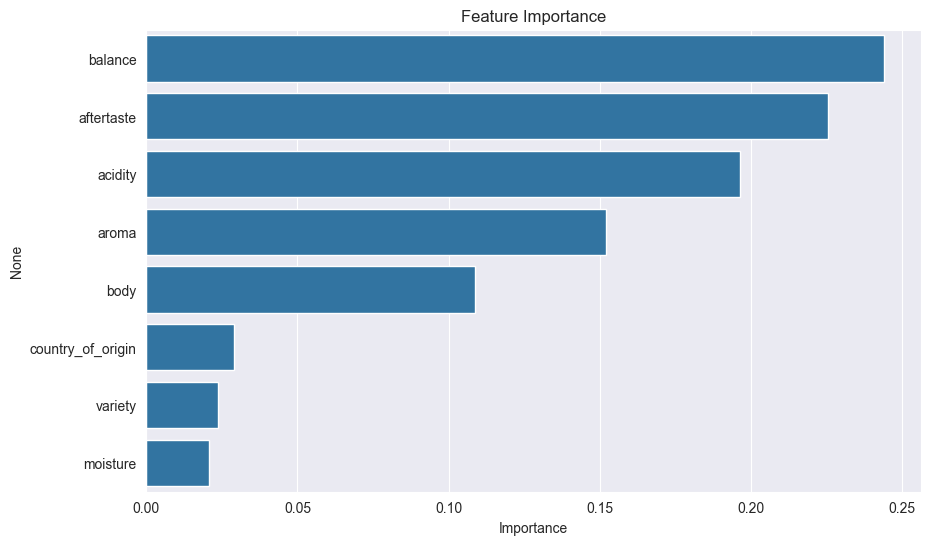

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance['Importance'], y=feature_importance.index)
plt.title('Feature Importance')
plt.show()
plt.close()